# Mid-Lap Predictor

## 00 - Introduction & Project Overview

## 01 - Data Collection

In [173]:
import fastf1 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import fastf1.plotting 
import numpy as np

Enabling cache is highly encouraged to speed up the runtime when re-running scripts.

In [ ]:
fastf1.Cache.enable_cache('../cache') # Enable caching to speed up data retrieval

The `get_session()` function is essential for data collection. This function allows us to grab sessions by inputting a particular season, grand prix, and session type (practice, qualifying, race).

In [ ]:
# Extract all laps from each session
for session in ['FP1', 'FP2', 'FP3', 'Q']:
    session_data = fastf1.get_session(2025, 'Hungary', session)
    session_data.load()
    
    laps = session_data.laps.to_csv(f'../data/raw/2025_Hungary_{session}_laps.csv', index=False)
    print(f'Saved {session} laps data to CSV.')

 Above we extract laps from practice and qualifying session however, many of the laps collected will be laps that are considered 'not accurate'. This means that many of the laps could be inlaps, outlaps, etc. So we will use the function `pick_quicklaps()` to help extract non-flying laps and laps that are faster than a specific threshold (default is 107% of the best lap).

In [ ]:
# Extract quick laps from all sessions
for session in ['FP1', 'FP2', 'FP3', 'Q']:
    session_data = fastf1.get_session(2025, 'Hungary', session)
    session_data.load()
    
    laps = session_data.laps.pick_quicklaps() # Pick only quick laps
    laps.to_csv(f'../data/raw/2025_Hungary_{session}_quicklaps.csv', index=False)
    print(f'Saved {session} laps data to CSV.')

To make reading the files more efficient, we will combine the laps from each session and create a new column for tagging each session (e.g. FP1, FP2, FP3, Q)

In [ ]:
sessions = ['FP1','FP2','FP3','Q']

lap_filepaths = [f'../data/raw/2025_Hungary_{s}_laps.csv' for s in sessions] 
ql_filepaths = [f'../data/raw/2025_Hungary_{s}_quicklaps.csv' for s in sessions]

lap_output = '../data/raw/2025_Hungary_all_laps.csv'
ql_output = '../data/raw/2025_Hungary_all_quicklaps.csv'

dfs = [] # List to hold dataframe for the laps
for sess, fp in zip(sessions, ql_filepaths): # Iterate over sessions and filepaths using zip()
    df = pd.read_csv(fp) # Read the CSV file into a DataFrame
    df['SessionType'] = sess # Add a new column for session type
    dfs.append(df) 

all_laps = pd.concat(dfs, ignore_index=True) # Concatenate all DataFrames into one
all_laps.to_csv(ql_output, index=False) 

The reason we will need these two seperate files is because using the `pick_quicklaps()` filters out laps that are inlaps and outlaps which we may need later on if we wanted to possibly research features such as tire degradation and the lap time loss due to tire deg.

In [ ]:
# Read laps and quicklaps data
laps = pd.read_csv('../data/raw/2025_Hungary_all_laps.csv')
quicklaps = pd.read_csv('../data/raw/2025_Hungary_all_quicklaps.csv')

print(laps.shape)
print(quicklaps.shape)

## 02 - Data Cleaning

In [ ]:
# Need to convert to time delta first, then to seconds
laps['LapTime (s)'] = pd.to_timedelta(laps['LapTime']).dt.total_seconds()
laps['Sector1Time (s)'] = pd.to_timedelta(laps['Sector1Time']).dt.total_seconds()
laps['Sector2Time (s)'] = pd.to_timedelta(laps['Sector2Time']).dt.total_seconds()
laps['Sector3Time (s)'] = pd.to_timedelta(laps['Sector3Time']).dt.total_seconds()
laps['TyreLife'] = laps['TyreLife'].astype(int)

In [ ]:
quicklaps['LapTime (s)'] = pd.to_timedelta(quicklaps['LapTime']).dt.total_seconds()
quicklaps['Sector1Time (s)'] = pd.to_timedelta(quicklaps['Sector1Time']).dt.total_seconds()
quicklaps['Sector2Time (s)'] = pd.to_timedelta(quicklaps['Sector2Time']).dt.total_seconds()
quicklaps['Sector3Time (s)'] = pd.to_timedelta(quicklaps['Sector3Time']).dt.total_seconds()
quicklaps['TyreLife'] = quicklaps['TyreLife'].astype(int)

In [ ]:
# Quick check to filter out any lap times that are deleted and not accurate
quicklaps = quicklaps[(quicklaps['Deleted'] == False) & (quicklaps['IsAccurate'] == True)]

The `describe()` is a great function to help analyze the dataset and make sure that there are no significant outliers skewing the data. As you can see when we print the statistics with `describe()`, the difference between **unfiltered** and the **quicklaps** is significant. The unfiltered laps have a mean laptime of 97.84 seconds whereas the quicklaps have a mean laptime of 77.35 seconds.

In [ ]:
print('Unfiltered Laps\n',laps[['LapTime (s)', 'Sector1Time (s)', 'Sector2Time (s)', 'Sector3Time (s)', 'TyreLife']].describe())
print('Quick Laps\n',quicklaps[['LapTime (s)', 'Sector1Time (s)', 'Sector2Time (s)', 'Sector3Time (s)', 'TyreLife']].describe())

In [ ]:
laps.to_csv('../data/processed/2025_Hungary_all_laps_cleaned.csv', index=False)
quicklaps.to_csv('../data/processed/2025_Hungary_all_quicklaps_cleaned.csv', index=False)

## 03 - Exploratory Data Analysis

In [ ]:
plt.style.use('dark_background') # Enable dark background for plt

### 3.1 Lap Time Distribution by Tire Compound

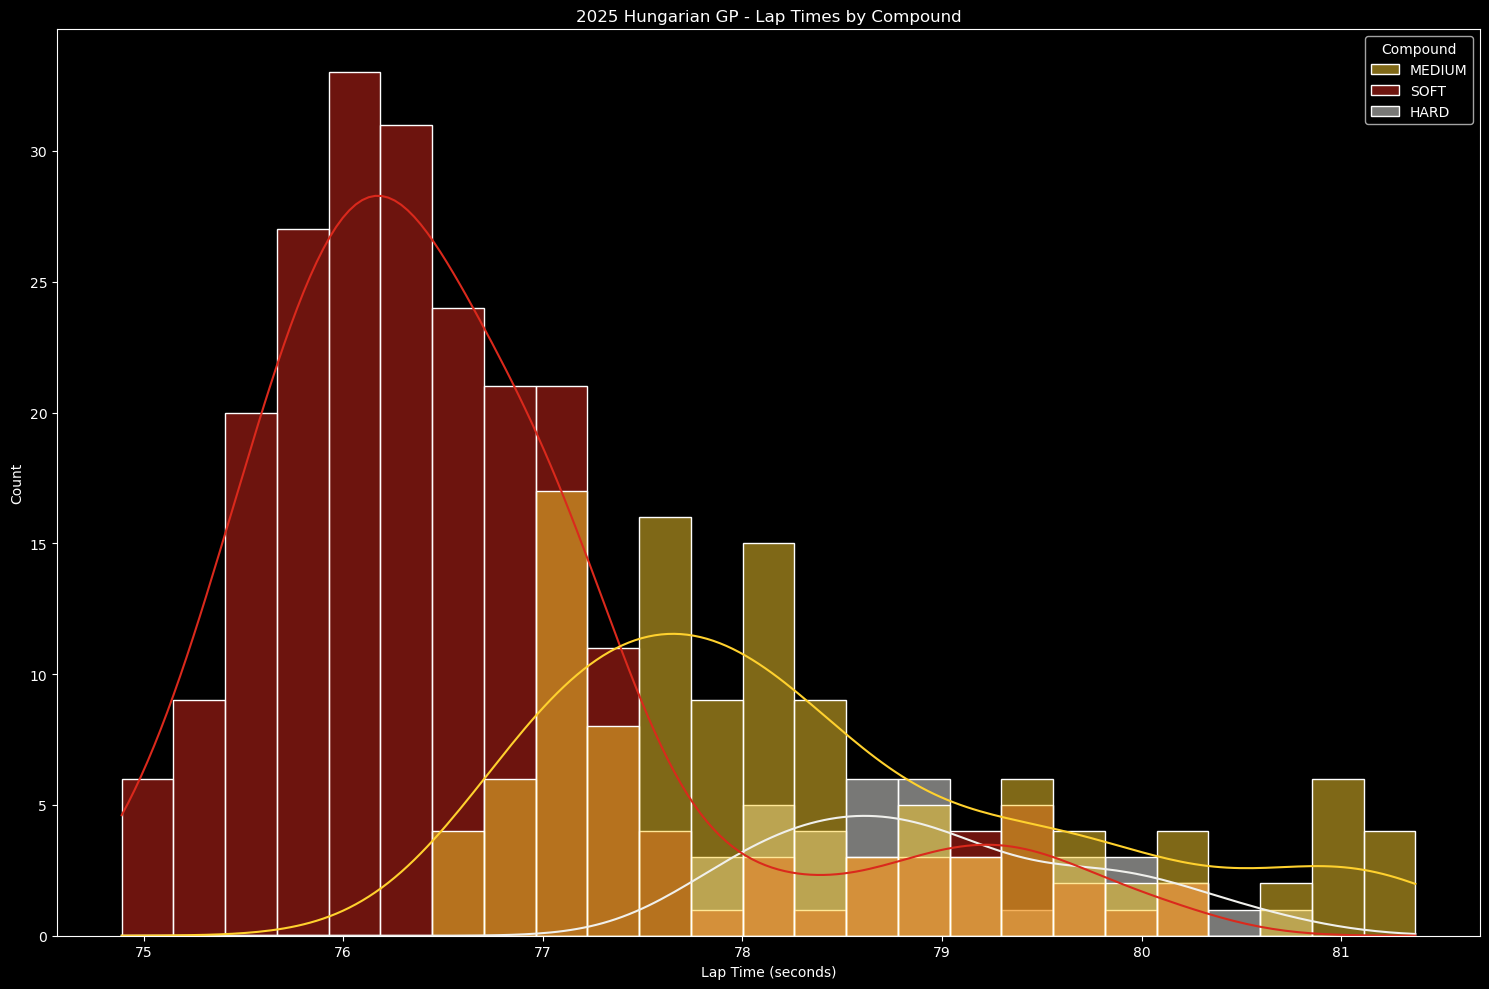

In [115]:
session = fastf1.get_session(2025, 'Hungary', 'FP1') 
compound_colors = fastf1.plotting.get_compound_mapping(session) # Returns a dictionary of compounds and its hexadecimal rgb color

plt.figure(figsize=(15, 10))

sns.histplot(
    data=quicklaps,
    x='LapTime (s)',
    hue='Compound',
    kde=True,
    bins=25,
    palette=compound_colors
)
plt.title('2025 Hungarian GP - Lap Times by Compound')
plt.xlabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

**Observation:**

**Soft compounds laps cluster around 76 seconds and has a tighter spread compared to the other compounds**. Mediums are slower than softs on average but have more variation and a wider spread compared to the Softs. The Hards are the slowest compounds but have a lower variance than the Mediums and is more consistent.

**Why it Matters:**

This confirms the performance hierarchy of tire compounds in lap time but also shows us the inconsistency in Mediums. For lap time prediction, tire compound could be a key feature for modeling pace differences.

**Action Items:**
- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- Find and filter out outliers within each compound category to improve model training stability.

### 3.2 Relationship Between Lap Time and Tire Compounds

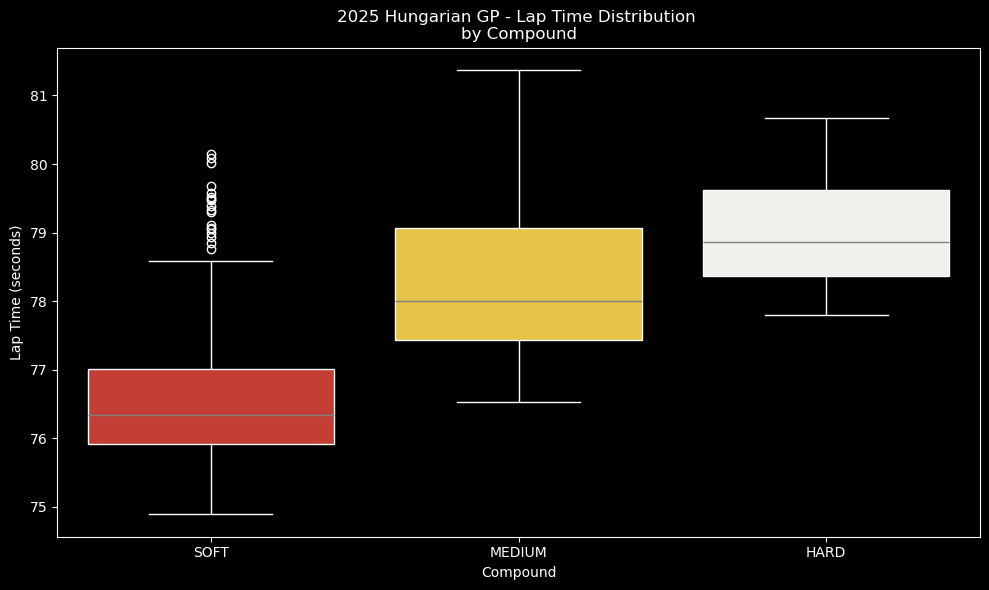

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=quicklaps,
    x='Compound',
    y='LapTime (s)',
    hue='Compound',
    palette=compound_colors,
    order=['SOFT', 'MEDIUM', 'HARD'],     
    whiskerprops=dict(color='white'),
    boxprops=dict(edgecolor='white'),
    medianprops=dict(color='grey'),
    capprops=dict(color='white'),
    flierprops=dict(markeredgecolor='white'),
)
plt.title('2025 Hungarian GP - Lap Time Distribution \nby Compound')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

**Observation:**

The **Soft compound has the lowest mean lap time (~76.3 seconds)** and has the **narrowest IQR (~1.1 seconds)**, showing that many of the lap times placed with the Softs are close to the median and is consistent. **Mediums are slower on average (~78.3 seconds)** with a **slight higher variance (~1.6 seconds)**. **Hard compound are the slowest on average (~78.9)** with a **slightly more consistent IQR than mediums (~1.3 seconds)**. There are many outliers with the Soft compounds that may need to be filtered out.

**Why it Matters:**

This supports the hierarchy between the compounds and gives us an idea of how much time is gained/loss depending on the choice of compound. This plot also helped us see outliers that we could not have seen precisely with the histogram, these outliers could possibly effect our model's performance and accuracy.

**Action Items:**

- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- Explore the outliers with the Soft compounds and potentially remove them.


### 3.3 Dealing with Soft Compound Outliers

Here we will explore the Soft compound outliers and observe if the outliers are worth removing from the dataset. We want to make sure that the outliers do not significantly effect our model later on. We will start by calculating the percentiles, interquartile range, upper, and lower bounds for each compound. Then we will create a function that checks if a row is outside of the bounds and mark those rows as outliers to easily flag outliers.

#### 3.3.1 Flagging Rows as Outliers

In [ ]:
q1 = quicklaps.groupby('Compound')['LapTime (s)'].quantile(0.25) # Return 25th percentile grouped by compound
q3 = quicklaps.groupby('Compound')['LapTime (s)'].quantile(0.75) # Return 75th percentile grouped by compound
iqr = q3 - q1 # Calculate interquartile range
upper_bound = q3 + 1.5 * iqr # Calculate upper bound for outliers
lower_bound = q1 - 1.5 * iqr # Calculate lower bound for outliers

In [ ]:
def is_outlier(row, lower_bound, upper_bound):
    """
    Determines whether a lap time is an outlier based on its IQR bounds.

    Parameters:
        row (pd.Series): A single row from the DataFrame containing LapTime and Compound.
        lower_bound (pd.Series): Lower bound values indexed by compound.
        upper_bound (pd.Series): Upper bound values indexed by compound.

    Returns:
        bool: True if the lap time is an outlier, False otherwise.
    """
    compound = row['Compound']
    lap_time = row['LapTime (s)']
    
    return (lap_time > upper_bound.loc[compound]) or (lap_time < lower_bound.loc[compound])

In [ ]:
# Apply the is_outlier function to each row in the DataFrame
quicklaps['IsOutlier'] = quicklaps.apply(is_outlier, axis=1, args=(lower_bound, upper_bound))

In [ ]:
soft_outliers = quicklaps[(quicklaps['Compound'] == 'SOFT') & (quicklaps['IsOutlier'])] # Filter for soft tire outliers
print('Outliers for Soft Compound\n', soft_outliers[['Driver', 'LapTime (s)']])

#### 3.3.2 Comparing Statistics (Outliers vs. Without Outliers)
Now that we have flagged the Soft compound outliers, we will calculate and compare the statistics with and without outliers.

In [ ]:
# Statistics with outliers
print("With Outliers:\n", quicklaps.groupby("Compound")["LapTime (s)"].describe()) 
print('\nVariance with outliers:\n', quicklaps.groupby("Compound")["LapTime (s)"].var())
print('\nStandard Deviation with outliers:\n', quicklaps.groupby("Compound")["LapTime (s)"].std())
print('---------------------------------------------')

# Statistics without soft outliers
quicklaps_no_soft_outliers = quicklaps[~((quicklaps['Compound'] == 'SOFT') & (quicklaps['IsOutlier']))]
print("Without Soft Outliers:\n", quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].describe()) 
print('\nVariance without soft outliers:\n', quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].var())
print('\nStandard Deviation without soft outliers:\n', quicklaps_no_soft_outliers.groupby("Compound")["LapTime (s)"].std())

From the results we can see a decrease in variance and the standard deviation for Soft compound without the outliers. In fact, there was a reduction in variance for the soft compound from **~1.13** to **~0.49** and a standard deviation reduction from **~1.06** to **~0.70**. This means that if we remove the Soft compound outliers, we would achieve a more consistent dataset and a higher quality model later on.

#### 3.3.2 Removing Soft Compound Outliers

In [ ]:
cleaned_quicklaps = quicklaps_no_soft_outliers

### 3.4 Relationship Between Lap Time and Tire Compounds (Soft Outliers Removed)

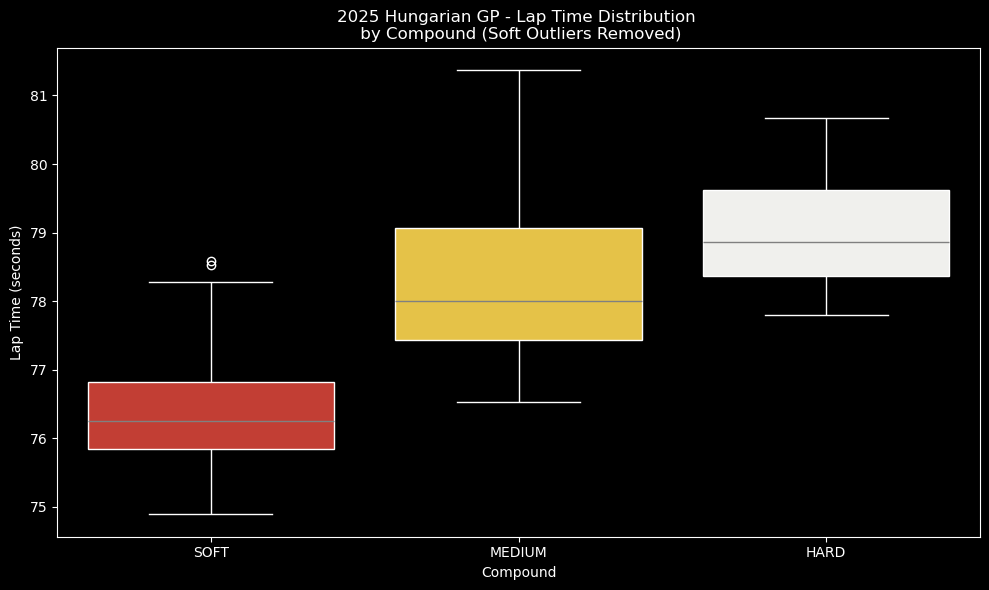

In [120]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=cleaned_quicklaps,
    x='Compound',
    y='LapTime (s)',
    hue='Compound',
    palette=compound_colors,
    order=['SOFT', 'MEDIUM', 'HARD'],     
    whiskerprops=dict(color='white'),
    boxprops=dict(edgecolor='white'),
    medianprops=dict(color='grey'),
    capprops=dict(color='white'),
    flierprops=dict(markeredgecolor='white'),
)

plt.title('2025 Hungarian GP - Lap Time Distribution \n by Compound (Soft Outliers Removed)')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

In [ ]:
print('Soft Compound Statistics:\n', cleaned_quicklaps[cleaned_quicklaps['Compound'] == 'SOFT']['LapTime (s)'].describe())

**Observation:**

After removing the outliers from the Soft compound, the number of extreme lap times decreased substantially. A few points still remain outside the boxplot whiskers, but these are not significant based on the `.describe()` results. **The maximum lap time for Softs is now ~78.58 seconds**, while the **mean is ~76.34 seconds**.

**Why it Matters:**

Removing the significant outliers reduces noise in the dataset, lowering the variance and standard deviation for Softs. This increases the consistency of lap time data and should improve model quality later on when we work on our model. The remaining Soft laps are within a normal range and may represent legitimate slower laps, so they will be left in the dataset for now.


**Action Items:**

- Encode tire compound (e.g. One Hot Encoding) for capturing pace differences between tire compounds.
- Consider interaction features between compound and tire life, since tire degradation can impact lap times.
- After feature engineering, assess if the outliers were valid outliers due to race conditions or not.


### 3.5 LapTime vs Tire Life: Detecting Effects of Tire Degradation

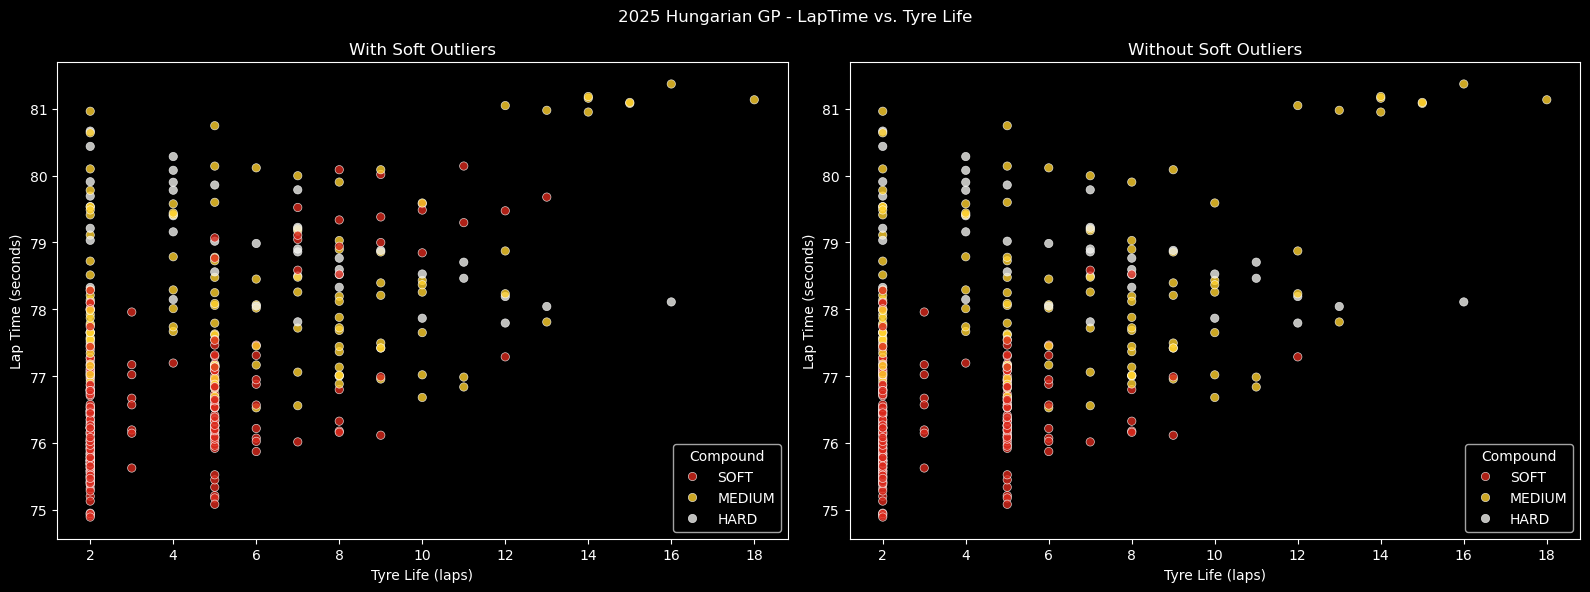

In [164]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))

order = ["SOFT", "MEDIUM", "HARD"]

sns.scatterplot(data = quicklaps, 
                x = 'TyreLife', 
                y = 'LapTime (s)', 
                hue = 'Compound', 
                hue_order= order,
                palette = compound_colors, 
                alpha=0.8,
                ax = ax[0])
sns.scatterplot(data = cleaned_quicklaps, 
                x='TyreLife', 
                y='LapTime (s)', 
                hue ='Compound', 
                hue_order= order,
                palette = compound_colors, 
                alpha=0.8,
                ax = ax[1])

fig.suptitle('2025 Hungarian GP - LapTime vs. Tyre Life')
ax[0].set_title('With Soft Outliers')
ax[1].set_title('Without Soft Outliers')

for a in ax: 
    a.set_xlabel('Tyre Life (laps)')
    a.set_ylabel('Lap Time (seconds)')

plt.tight_layout()
plt.show()

**Observation:**

The Soft compound has a consistent performance between the tire life of 2-5 laps at ~75-78 seconds, then the lap time starts spread upwards after lap 6 showing outliers that could be due to tire degradation. We can see several outliers for the Medium compound as well that could be explained by tire degradation. The Hard compound has a steady performance with some outliers beyond a tire life of 10 laps.


**Why it Matters:**

Seeing the performance decrease as a stint extends gives us an idea of how much tire degradation impacts performance. This can help our model learn the pace drop-off as tire life increases.

**Action Items:**

- Consider tire degradation as a feature to capture the impact of pace as stint extends.
- Train a "cleaned" model with the Soft compound outliers removed and compare model performances.

### 3.6 Impact of Teams on Pace

In [138]:
team_order = (quicklaps[['Team', 'LapTime (s)']]
                .groupby('Team')
                .median()
                .sort_values('LapTime (s)')
                .index)
print(team_order)

team_palette = {team: fastf1.plotting.get_team_color(team, session = session) for team in team_order}

Index(['McLaren', 'Ferrari', 'Aston Martin', 'Mercedes', 'Racing Bulls',
       'Haas F1 Team', 'Williams', 'Alpine', 'Red Bull Racing', 'Kick Sauber'],
      dtype='object', name='Team')


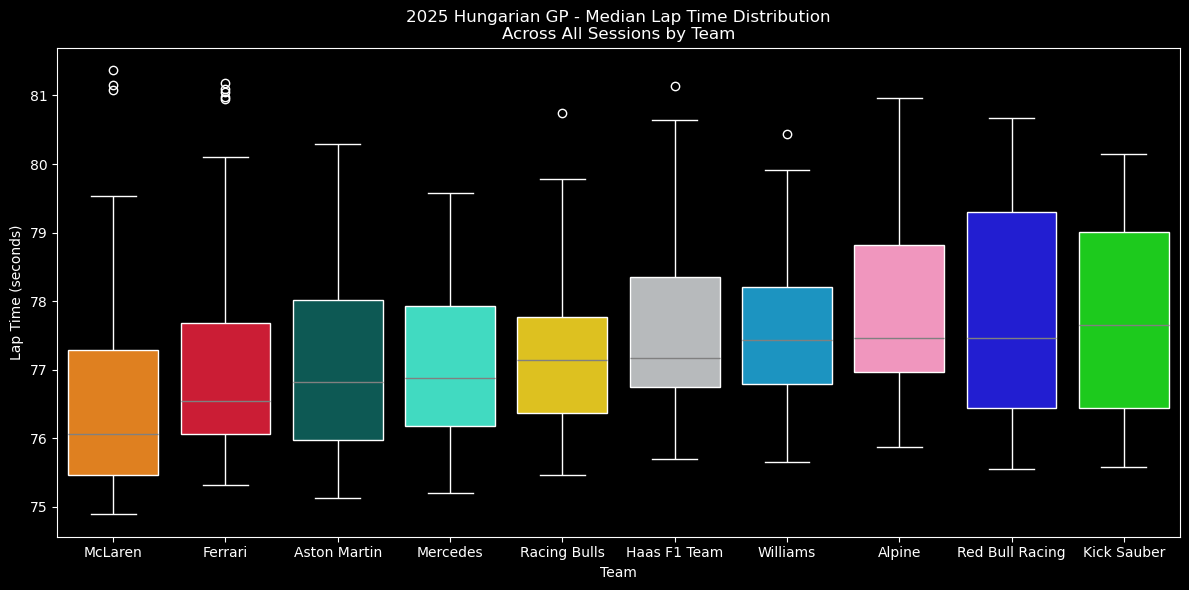

In [196]:
plt.figure(figsize=(12, 6))
sns.boxplot(data = quicklaps,
            x = 'Team', 
            y = 'LapTime (s)', 
            hue = 'Team', 
            palette = team_palette, 
            order = team_order,
            whiskerprops=dict(color='white'),
            boxprops=dict(edgecolor='white'),
            medianprops=dict(color='grey'),
            capprops=dict(color='white'),
            flierprops=dict(markeredgecolor='white'),
            )

plt.title('2025 Hungarian GP - Median Lap Time Distribution\nAcross All Sessions by Team')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

In [142]:
fp1 = quicklaps[quicklaps['SessionType'] == 'FP1']
fp2 = quicklaps[quicklaps['SessionType'] == 'FP2']
fp3 = quicklaps[quicklaps['SessionType'] == 'FP3']
qualy = quicklaps[quicklaps['SessionType'] == 'Q']

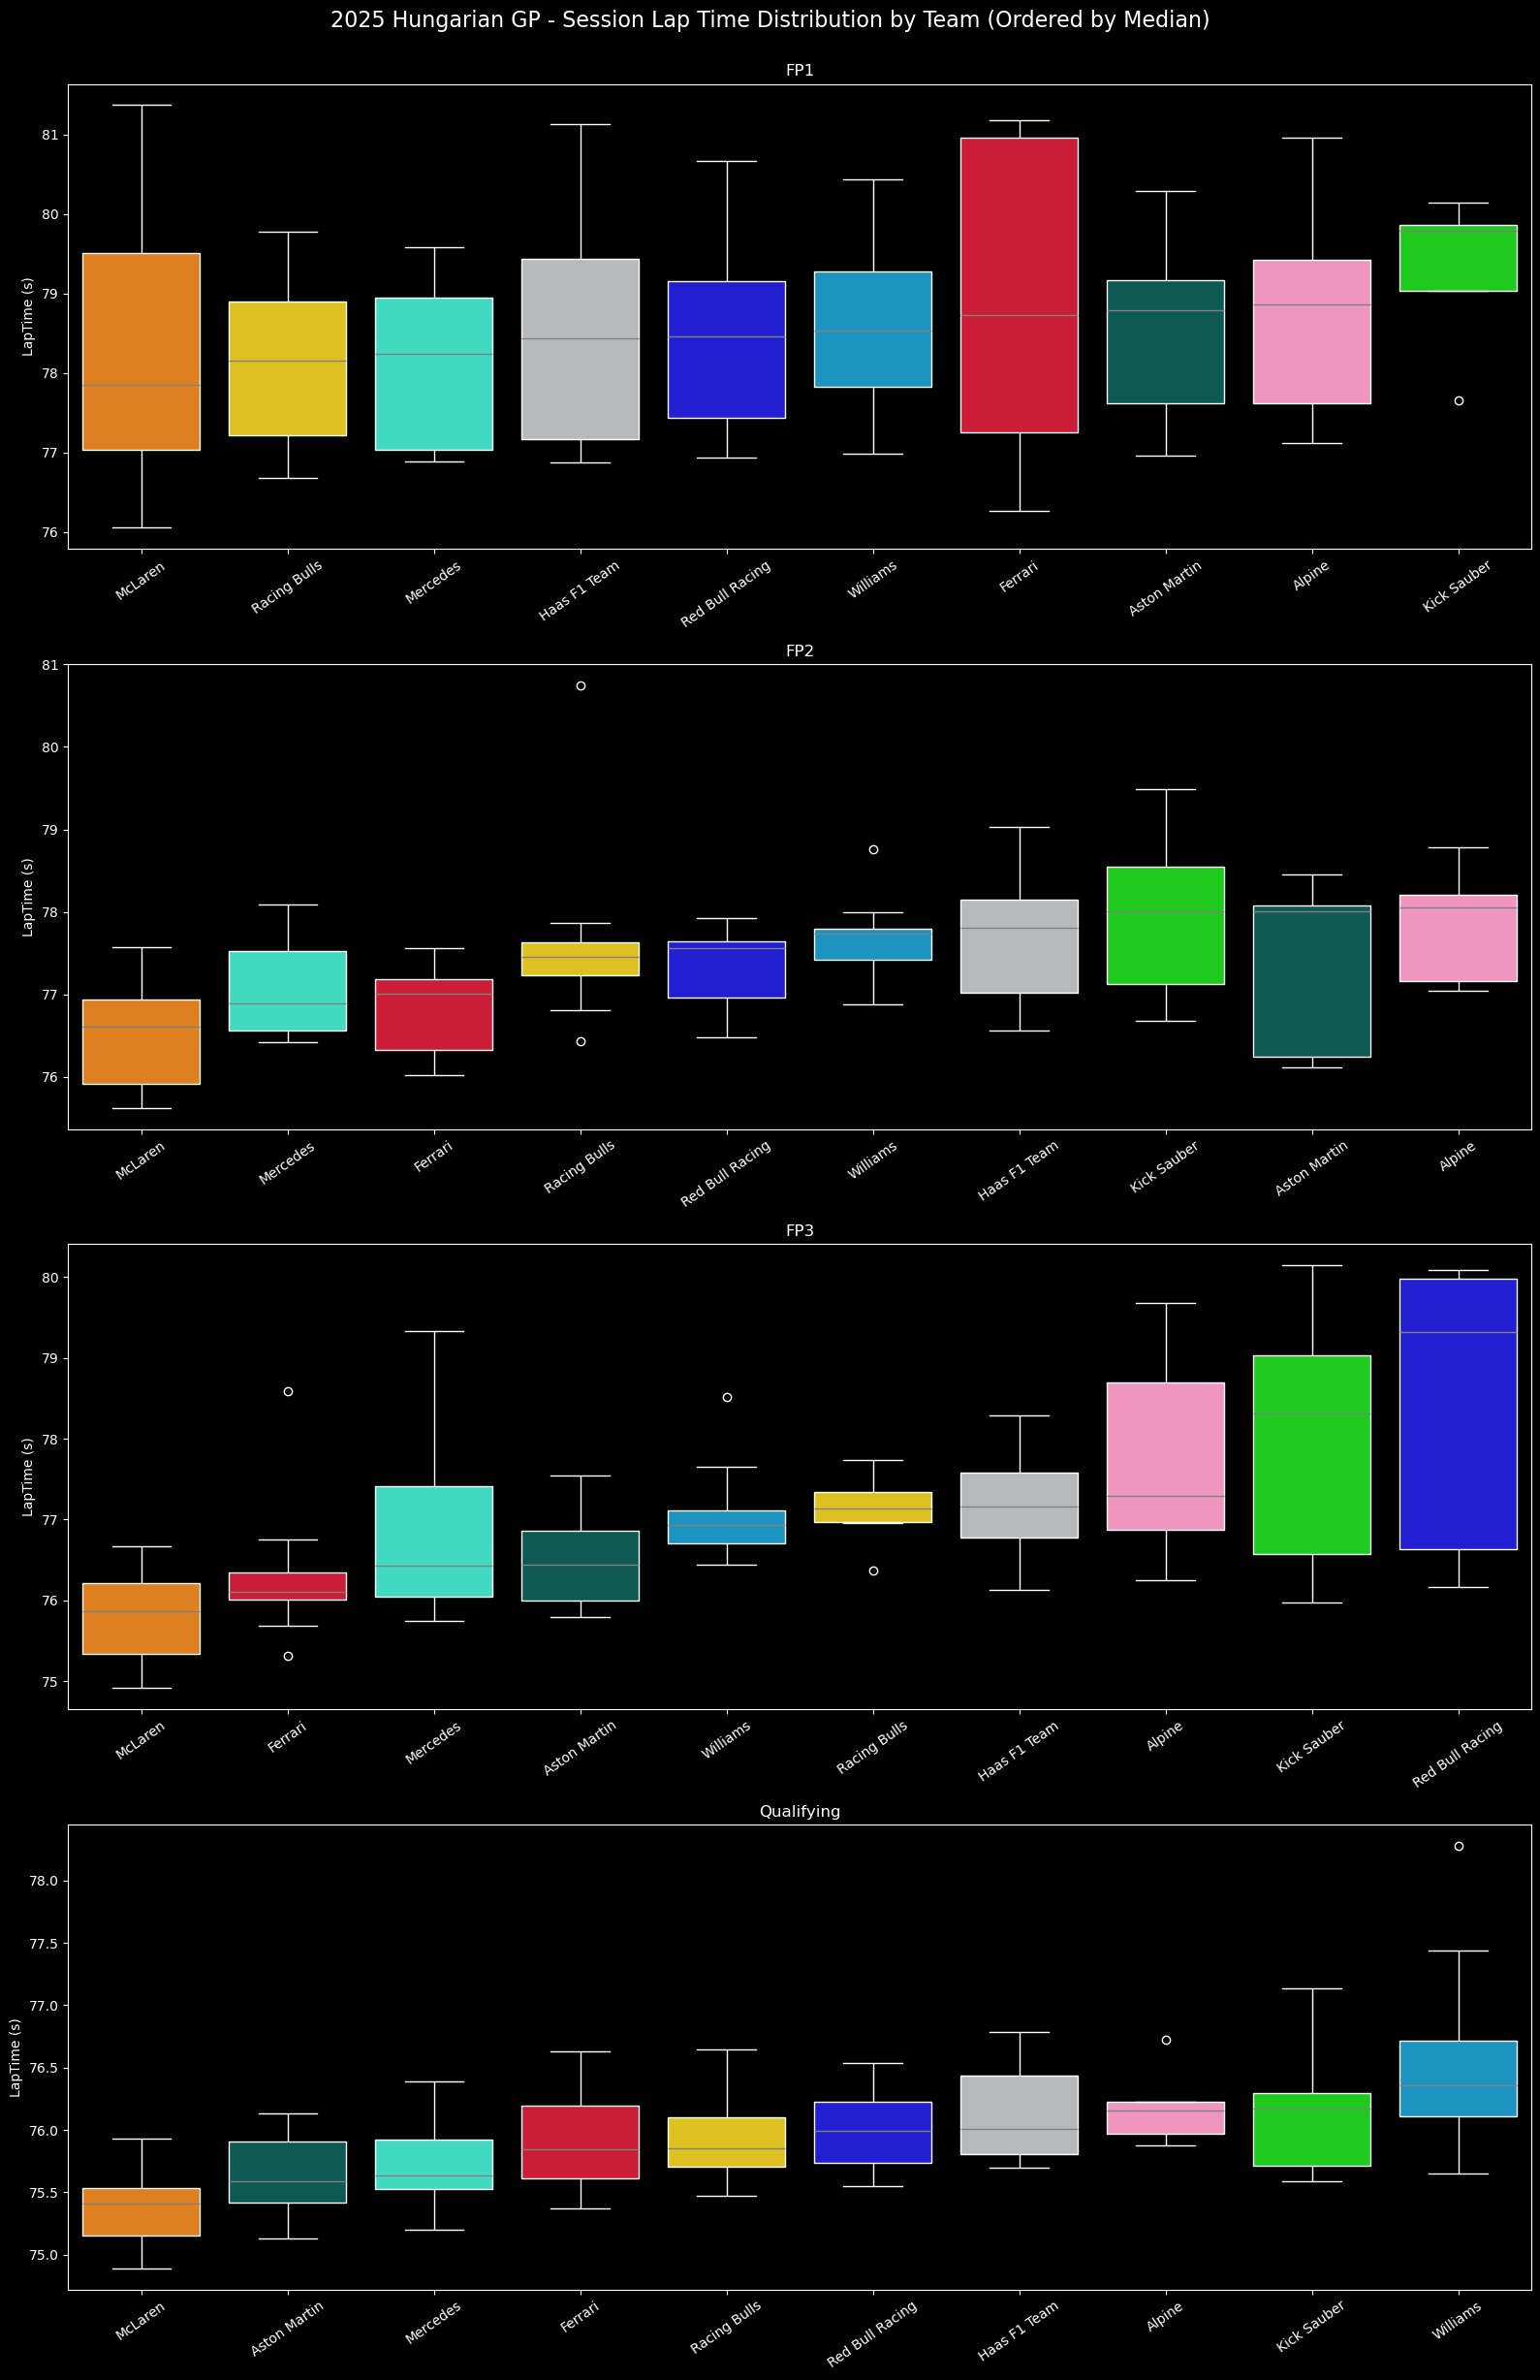

In [200]:
sessions = {
    'FP1': fp1,
    'FP2': fp2,
    'FP3': fp3,
    'Qualifying': qualy
}

fig, axs = plt.subplots(4, 1, figsize=(16, 25))

for ax, (title, df) in zip(axs, sessions.items()): 
    order = (
        df[['Team', 'LapTime (s)']]
        .groupby('Team')
        .median()
        .sort_values('LapTime (s)')
        .index
    )
    
    sns.boxplot(data = df,
                x = 'Team',
                y = 'LapTime (s)',
                hue = 'Team',
                palette = team_palette,
                order = order,
                whiskerprops=dict(color='white'),
                boxprops=dict(edgecolor='white'),
                medianprops=dict(color='grey'),
                capprops=dict(color='white'),
                flierprops=dict(markeredgecolor='white'), 
                ax=ax
                )
    
    ax.set_title(title)
    ax.set_xlabel("")                      
    ax.tick_params(axis = 'x', rotation = 35)  
    
fig.suptitle("2025 Hungarian GP - Session Lap Time Distribution by Team (Ordered by Median)\n\n", fontsize=16)

plt.tight_layout()
plt.show()
                

## 04 - Feature Engineering

## 05 - Modeling

## 06 - Insights & Interpretation

## 07 - Conclusion & Next Steps